In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get cleaned data
data = pd.read_csv("cleaned.csv")
data.head()

,Unnamed: 0,timestamp,likeable,surprising,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,age,gender,edu,group
0,0,2019/01/10 11:13:00 AM EST,7.0,3.0,-88.0,15.0,1.0,15.0,33.0,-80.0,-33.0,58.0,-50.0,33.0,27.0,m,4yr,0
1,1,2019/01/10 11:32:59 AM EST,4.0,5.0,-30.0,30.0,1.0,14.0,10.0,-50.0,-5.0,51.0,-30.0,10.0,18.0,m,high,0
2,2,2019/01/10 11:33:55 AM EST,3.0,3.0,-85.0,20.0,3.0,35.0,36.0,-86.0,100.0,50.0,-30.0,300.0,21.0,m,high,0
3,3,2019/01/10 11:34:50 AM EST,7.0,3.0,-88.0,30.0,1.0,15.0,30.0,-88.0,-33.0,56.0,-51.0,300.0,45.0,m,4yr,0
4,4,2019/01/10 11:35:08 AM EST,7.0,7.0,-86.0,32.0,1.0,26.0,32.0,-36.0,16.0,56.0,-17.0,40.0,17.0,m,none,0


In [3]:
# Time to calculate THE SCORES!

# See my pre-registration for the rationale behind the formula:
# https://blog.ncase.me/my-experiment-pre-registration/

# For each Q:
# x = (guess/answer)
# y = _/\_-shaped, peaks at 1.0 +/- 0.5
#   = max( 0, 1-2*abs(x-1) )

# Correct answers:
# 1 (poverty): -88
# 2 (air pollution): +25
# 3 (violence): +1
# 4 (mental): +15
# 5 (heart): +32
# 6 (nukes): -84
# 7 (suicide): -33
# 8 (democracy): +56
# 9 (fertility): -51
# 10 (CO2): +302

correct_answers = {
    'q1': -88,
    'q2': +25,
    'q3': +1,
    'q4': +15,
    'q5': +32,
    'q6': -84,
    'q7': -33,
    'q8': +56,
    'q9': -51,
    'q10': +302
}

def calculate_score(row):
    total_points = 0
    
    # for each q...
    for i in range(10):
        q_name = "q" + str(i+1)
        guess = row[q_name]
        answer = correct_answers[q_name]
        # calculate & add...
        x = (guess/answer)
        y = max( 0, 1-2*abs(x-1) )
        total_points += y
       
    # gimme!
    return total_points

data['score'] = data.apply(lambda row: calculate_score(row), axis=1)
data.head()

,Unnamed: 0,timestamp,likeable,surprising,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,age,gender,edu,group,score
0,0,2019/01/10 11:13:00 AM EST,7.0,3.0,-88.0,15.0,1.0,15.0,33.0,-80.0,-33.0,58.0,-50.0,33.0,27.0,m,4yr,0,7.931618
1,1,2019/01/10 11:32:59 AM EST,4.0,5.0,-30.0,30.0,1.0,14.0,10.0,-50.0,-5.0,51.0,-30.0,10.0,18.0,m,high,0,3.655042
2,2,2019/01/10 11:33:55 AM EST,3.0,3.0,-85.0,20.0,3.0,35.0,36.0,-86.0,100.0,50.0,-30.0,300.0,21.0,m,high,0,5.183139
3,3,2019/01/10 11:34:50 AM EST,7.0,3.0,-88.0,30.0,1.0,15.0,30.0,-88.0,-33.0,56.0,-51.0,300.0,45.0,m,4yr,0,9.366517
4,4,2019/01/10 11:35:08 AM EST,7.0,7.0,-86.0,32.0,1.0,26.0,32.0,-36.0,16.0,56.0,-17.0,40.0,17.0,m,none,0,4.394545


In [4]:
import math
from scipy.stats import ttest_ind

# Calculate effect size, p-value
# for Score, Likeable, and Surprising
control = data[data["group"]==0]
experimental = data[data["group"]==1]
metrics = {
    "score": {},
    "likeable": {},
    "surprising": {}
}

# Standardized Effect Size (Cohen's d)
def cohend(col):
    d1 = experimental[col]
    d2 = control[col]
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s
metrics["score"]["d"] = cohend("score")
metrics["likeable"]["d"] = cohend("likeable")
metrics["surprising"]["d"] = cohend("surprising")

# P-Value
def get_p(col):
    return ttest_ind(experimental[col], control[col]).pvalue
metrics["score"]["p"] = get_p("score")
metrics["likeable"]["p"] = get_p("likeable")
metrics["surprising"]["p"] = get_p("surprising")

# Let's see it
metrics

{'score': {'d': -0.004416331890078157, 'p': 0.9291907434347007},
 'likeable': {'d': 0.5496709310749239, 'p': 1.8023150053255885e-27},
 'surprising': {'d': 0.5126581126827132, 'p': 3.2600809813287064e-24}}

/Users/ncase/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


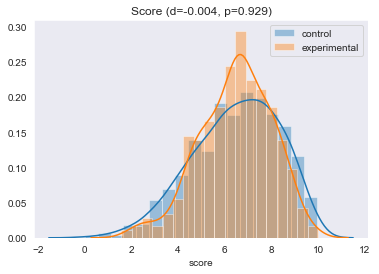

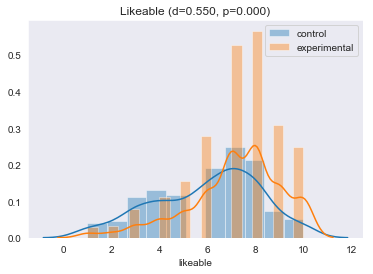

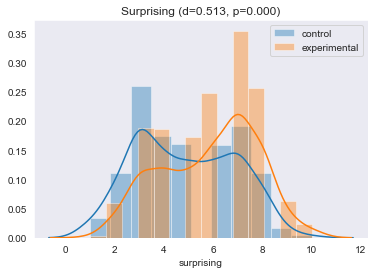

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

# Draw histograms for Score, Likeable, Surprising
for key, stats in metrics.items():
    
    sns.distplot(control[key], label="control")
    sns.distplot(experimental[key], label="experimental")
    
    d_string = "{0:.3f}".format(stats["d"])
    p_string = "{0:.3f}".format(stats["p"])
    
    plt.title(key.title()+" (d="+d_string+", p="+p_string+")")
    plt.legend()
    plt.show()

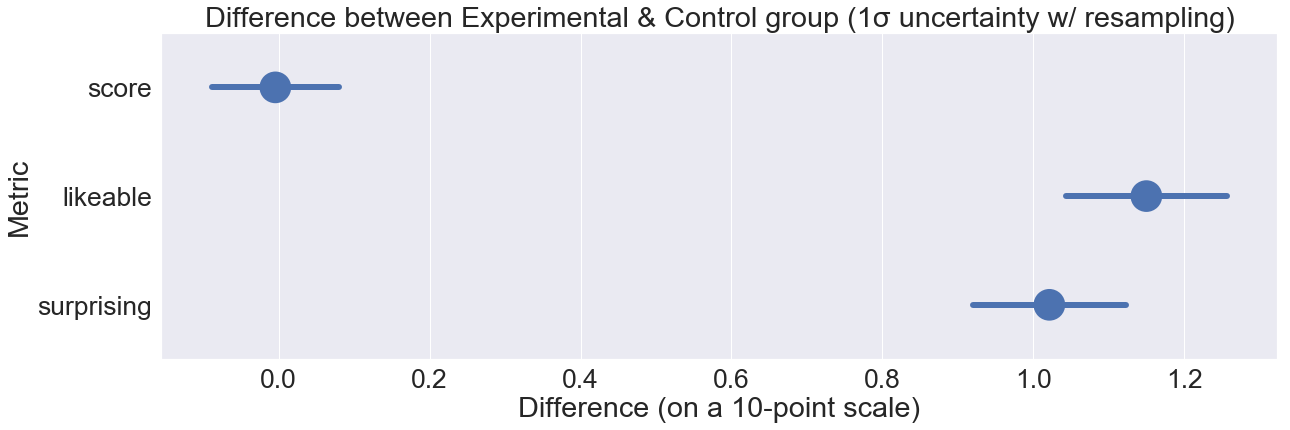

In [6]:
# Use resampling to get mean differences between experimental & control
diffs = {
    "score": [],
    "likeable": [],
    "surprising": []
}
resample_n = 1000
for i in range(resample_n):
    # Resample, and simulate calculating the mean diff between the two groups
    resampled_experimental = experimental.sample(n=experimental.shape[0], replace=True, random_state=i)
    resampled_control = control.sample(n=control.shape[0], replace=True, random_state=i)
    for key in diffs:
        diffs[key].append( resampled_experimental[key].mean() - resampled_control[key].mean() )
        
# Convert into a DF
lol = []
for key, resampled_diffs in diffs.items():
    for resampled_diff in resampled_diffs:
       lol.append([key, resampled_diff])
df = pd.DataFrame(lol, columns=["metric", "diff"])  

# Plot it! With only 1 SD because I can't figure out how to get Seaborn to do some basic bullshit
# and give me a pointplot with 95% CI on *the distribution*, not the mean, because this resampled data
# is ALREADY the means, god I hate data viz
fig = plt.figure(figsize=(10*2,3*2))
sns.set(font_scale=1.2*2)
sns.set_style("darkgrid")
ax = sns.pointplot(x="diff", y="metric", data=df, join=False, ci="sd", scale=1.8*2, errwidth=3*2)
ax.set(xlabel='Difference (on a 10-point scale)', ylabel='Metric', title='Difference between Experimental & Control group (1σ uncertainty w/ resampling)')
# fig.savefig('metrics.png', bbox_inches='tight')
plt.show()